In [1]:
import Simulator
import Observation
import Statistics

import KalmanFilter
import IEWParticleFilter

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Initialisation

print("Initialising...")

timestamp = "2021_08_11-14_10_29"
grid, simulator = Simulator.from_file(timestamp)

observation = Observation.from_file(grid, timestamp)

prior_args = Statistics.prior_args_from_file(timestamp)

print("done\n")

N_es = [1000] # No big difference in dependence of ensemble size... choose 100 as balance between fast and smooth


Initialising...
Remember to set observation positions and to set/observe values!
done



In [3]:
# Pois

pois = [[0,0], [25,15], [0,1]]

pois_idx = []
for p in pois:
    indicator_field = np.zeros((grid.ny, grid.nx))
    indicator_field[p[1],p[0]] = 1.0

    pois_idx.append(np.where(indicator_field.flatten() != 0 )[0][0])

In [4]:
betas = [None, 0.5, 0.55, 0.6]

-----------------------------------
-----------------------------------
 N_e = 1000
-----------------------------------
-----------------------------------
-----------------------------------
 beta = None
-----------------------------------
New true observations 0
KF DA
Please remember to set priors!
Ensemble init  0
IEWPF DA
[0.6905830795870367, 0.7931101236921256, 0.853703560187483, 0.910464465673222, 0.9378759392966292, 0.9589725360174406, 0.9573293896766317, 0.973147744903696, 0.9730467629111722, 0.9803374471720152]
Comparing
done

Ensemble init  1
IEWPF DA
[0.6204319367915991, 0.8133822963844096, 0.8469084993762129, 0.8958717291600256, 0.9461253851483686, 0.9475735097644314, 0.9450226381762246, 0.969017893084892, 0.9685036298224875, 0.9778359986880679]
Comparing
done

New true observations 1
KF DA
Please remember to set priors!
Ensemble init  0
IEWPF DA
[0.8388016414907697, 0.8668369289666303, 0.9393015049313599, 0.9468573502612229, 0.9651345238565526, 0.9644961316262752, 0.976459

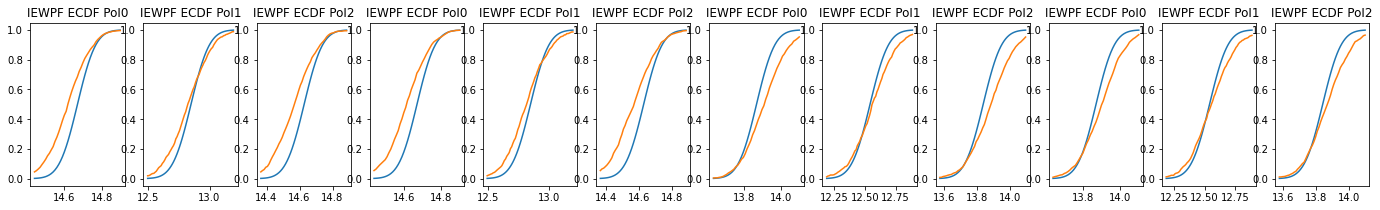

-----------------------------------
 beta = 0.5
-----------------------------------
New true observations 0
KF DA
Please remember to set priors!
Ensemble init  0
IEWPF DA
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Comparing
done

Ensemble init  1
IEWPF DA
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Comparing
done

New true observations 1
KF DA
Please remember to set priors!
Ensemble init  0
IEWPF DA
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Comparing
done

Ensemble init  1
IEWPF DA
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Comparing
done



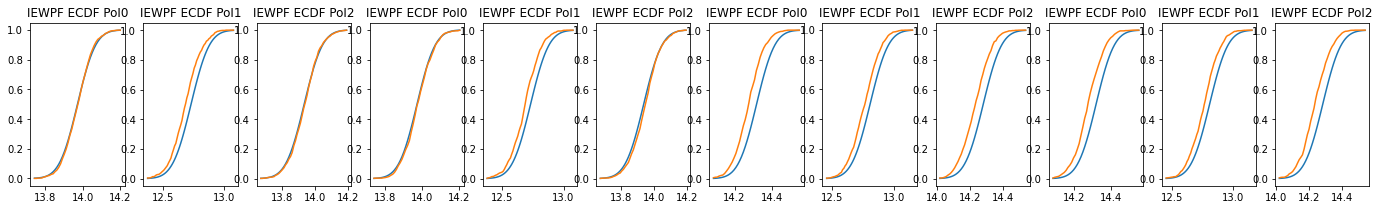

-----------------------------------
 beta = 0.55
-----------------------------------
New true observations 0
KF DA
Please remember to set priors!
Ensemble init  0
IEWPF DA


In [5]:
# Repeating ensemble runs
for N_e in N_es:

    print("-----------------------------------")
    print("-----------------------------------")
    print(" N_e = " + str(N_e) )
    print("-----------------------------------")
    print("-----------------------------------")

    for beta in betas:

        print("-----------------------------------")
        print(" beta = " + str(beta) )
        print("-----------------------------------")

        trials_truth = 2
        trials_init  = 2

        fig, axs = plt.subplots(1,(trials_truth*trials_init*len(pois_idx)), figsize=(24,3))

        for trail_truth in range(trials_truth):
            # Truth
            print("New true observations", trail_truth)
            observation.clear_observations()

            statistics_truth = Statistics.Statistics(simulator, 1)
            statistics_truth.set_prior(prior_args)

            for t in range(10):
                statistics_truth.propagate(25)
                observation.observe(statistics_truth.mean)
            
            # KF 
            print("KF DA")
            statistics_kf = Statistics.Statistics(simulator)
            statistics_kf.set_prior(prior_args)

            kalmanFilter = KalmanFilter.Kalman(statistics_kf, observation)

            for t in range(observation.N_obs):
                statistics_kf.propagate(25)
                kalmanFilter.filter(statistics_kf.mean, statistics_kf.cov, observation.obses[t])


            for trial_init in range(trials_init):
                print("Ensemble init ", trial_init)

                # IEWPF
                print("IEWPF DA")
                statistics_iewpf = Statistics.Statistics(simulator, N_e)
                statistics_iewpf.set_prior(prior_args)

                iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation, beta)

                for t in range(observation.N_obs):
                    statistics_iewpf.propagate(25, model_error=False)
                    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])

                print(iewpFilter.betas)

                # Comparison
                print("Comparing")
                
                trial = trail_truth*trials_init*len(pois) + trial_init*len(pois)
        
                for p in range(len(pois)):
                    cdf = lambda x: scipy.stats.norm.cdf(x, loc=statistics_kf.mean[pois_idx[p]], scale=statistics_kf.stddev[pois_idx[p]])

                    ecdf_iewpf = ECDF(statistics_iewpf.ensemble.ensemble[pois_idx[p],:])

                    xmin = statistics_kf.mean[pois_idx[p]] - 3*statistics_kf.stddev[pois_idx[p]]
                    xmax = statistics_kf.mean[pois_idx[p]] + 3*statistics_kf.stddev[pois_idx[p]]

                    X = np.arange(xmin, xmax, 0.01)

                    axs[trial+p].plot(X, cdf(X))
                    axs[trial+p].plot(X, ecdf_iewpf(X))
                    axs[trial+p].set_title("IEWPF ECDF PoI"+str(p))
                    
                print("done\n")

        plt.show()

